In [18]:
import math
import os
import sys
import time
import shutil
import logging
import argparse
import yaml
import traceback
from cvxopt import matrix, solvers

import numpy as np
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('poster')

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
pwd

'/atlas/u/madeline/multi-fairgen/notebooks'

In [4]:
cd /atlas/u/kechoi/libTLDA

/atlas/u/kechoi/libTLDA


----

# Load data

In [5]:
import numpy as np
import numpy.random as rnd
import torch

from sklearn.linear_model import LogisticRegression
from libtlda.iw import ImportanceWeightedClassifier

"""Generate synthetic data set"""

'Generate synthetic data set'

In [6]:
rec = np.load('/atlas/u/kechoi/multi-fairgen/data/kmm/source.npz')
X = rec['x']
y = rec['y']

rec = np.load('/atlas/u/kechoi/multi-fairgen/data/kmm/target.npz')
Z = rec['x']
u = rec['y']

rec = np.load('/atlas/u/kechoi/multi-fairgen/data/kmm/target_test.npz')
Z_test = rec['x']
u_test = rec['y']

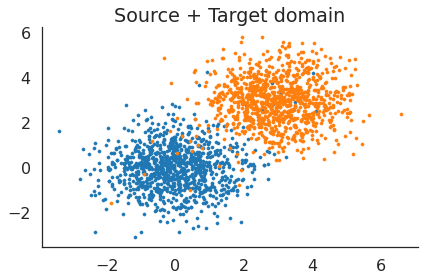

In [7]:
plt.scatter(X[:,0], X[:,1], s=10)
plt.scatter(Z[:,0], Z[:,1], s=10)

plt.title('Source + Target domain')
sns.despine()
plt.tight_layout()

In [8]:
# Train via KMM
clf = ImportanceWeightedClassifier(weight_estimator='kmm', bandwidth=0.05)
clf.fit(X, y, Z)
pred_adapt = clf.predict(Z)

# Train a naive logistic regressor
lr = LogisticRegression().fit(X, y)

# Make predictions
pred_naive = lr.predict(Z)


# Compute error rates
print('Error naive: ' + str(np.mean(pred_naive != u, axis=0)))
print('Error adapt: ' + str(np.mean(pred_adapt != u, axis=0)))

     pcost       dcost       gap    pres   dres
 0:  5.0469e+02 -3.2215e+04  3e+04  2e-16  1e+03
 1:  4.9481e+02 -3.1307e+03  4e+03  7e-17  1e+02
 2:  4.7565e+02  3.2915e+02  1e+02  1e-15  3e-14
 3:  4.7409e+02  4.7249e+02  2e+00  2e-15  6e-15
 4:  4.7403e+02  4.7402e+02  2e-02  2e-15  1e-14
 5:  4.7403e+02  4.7403e+02  2e-04  2e-15  3e-14
Optimal solution found.
Error naive: 0.297
Error adapt: 0.26


In [9]:
pred_adapt_test = clf.predict(Z_test)
pred_naive_test = lr.predict(Z_test)

# Compute error rates
print('Error naive: ' + str(np.mean(pred_naive_test != u_test, axis=0)))
print('Error adapt: ' + str(np.mean(pred_adapt_test != u_test, axis=0)))

Error naive: 0.286
Error adapt: 0.248


# Load pre-trained flow

In [10]:
cd ../multi-fairgen/src/

/atlas/u/kechoi/multi-fairgen/src


In [11]:
device = 'cpu'
restore_file = 'flows/results/kmm_flow/'
state = torch.load(os.path.join(restore_file, "best_model_checkpoint.pt"), map_location=device)
print(state['epoch'])

85


In [18]:
from flows.models.maf import MAF

def load_flow():
    model = MAF(5, 
                2, 
                100, 
                1, 
                None, 
                'relu', 
                'sequential', 
                batch_norm=True)
    restore_file = 'flows/results/kmm_flow/'
    state = torch.load(os.path.join(restore_file, "model_checkpoint.pt"), map_location=device)
    model.load_state_dict(state['model_state'])
    model = model.to(device)
    return model

flow = load_flow()
flow.eval()

MAF(
  (net): FlowSequential(
    (0): MADE(
      (net_input): MaskedLinear(in_features=2, out_features=100, bias=True)
      (net): Sequential(
        (0): ReLU()
        (1): MaskedLinear(in_features=100, out_features=100, bias=True)
        (2): ReLU()
        (3): MaskedLinear(in_features=100, out_features=4, bias=True)
      )
    )
    (1): BatchNorm()
    (2): MADE(
      (net_input): MaskedLinear(in_features=2, out_features=100, bias=True)
      (net): Sequential(
        (0): ReLU()
        (1): MaskedLinear(in_features=100, out_features=100, bias=True)
        (2): ReLU()
        (3): MaskedLinear(in_features=100, out_features=4, bias=True)
      )
    )
    (3): BatchNorm()
    (4): MADE(
      (net_input): MaskedLinear(in_features=2, out_features=100, bias=True)
      (net): Sequential(
        (0): ReLU()
        (1): MaskedLinear(in_features=100, out_features=100, bias=True)
        (2): ReLU()
        (3): MaskedLinear(in_features=100, out_features=4, bias=True)
      

Text(0.5, 1.0, 'Source + Target')

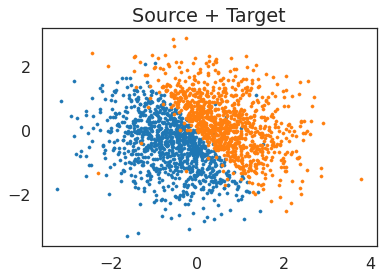

In [20]:
# encode data points
flow_train_x, _ = flow.forward(torch.from_numpy(X).cpu().float())
flow_test_x, _ = flow.forward(torch.from_numpy(Z).cpu().float())

plt.scatter(flow_train_x[:,0].data.cpu().numpy(), flow_train_x[:,1].data.cpu().numpy(), s=10)
plt.scatter(flow_test_x[:,0].data.cpu().numpy(), flow_test_x[:,1].data.cpu().numpy(), s=10)

plt.title('Source + Target')

In [21]:
# on target
clf = ImportanceWeightedClassifier(weight_estimator='kmm', bandwidth=0.1)
clf.fit(flow_train_x.data.cpu().numpy(), y, flow_test_x.data.cpu().numpy())
pred_adapt = clf.predict(flow_test_x.data.cpu().numpy())

print('Error adapt in z-space: ' + str(np.mean(pred_adapt != u, axis=0)))

     pcost       dcost       gap    pres   dres
 0:  6.6780e+02 -3.2202e+04  3e+04  9e-17  3e+02
 1:  6.5183e+02 -2.9739e+03  4e+03  1e-15  3e+01
 2:  6.2499e+02  5.0027e+02  1e+02  3e-16  8e-15
 3:  6.2102e+02  6.1662e+02  4e+00  8e-16  3e-14
 4:  6.2090e+02  6.2064e+02  3e-01  3e-16  1e-13
 5:  6.2089e+02  6.2089e+02  4e-03  5e-16  6e-13
 6:  6.2089e+02  6.2089e+02  5e-05  1e-15  4e-12
Optimal solution found.
Error adapt in z-space: 0.238


In [23]:
# target test
flow_test_real, _ = flow(torch.from_numpy(Z_test).float().cpu())
pred_adapt_test = clf.predict(flow_test_real.data.cpu().numpy())
print('Error adapt in z-space: ' + str(np.mean(pred_adapt_test != u_test, axis=0)))

Error adapt in z-space: 0.213


### previous results

(on target)
- Error naive: 0.297
- Error adapt: 0.26
 
(on target_test)
- Error naive: 0.286
- Error adapt: 0.248

What happens for z-space LR?

In [20]:
# Train a naive logistic regressor
z_lr = LogisticRegression().fit(flow_train_x.data.cpu().numpy(), y)

# Make predictions
pred_naive = z_lr.predict(flow_test_x.data.cpu().numpy())
print('Error naive: ' + str(np.mean(pred_naive != u, axis=0)))

Error naive: 0.635


In [21]:
pred_naive_test = z_lr.predict(flow_test_real.data.cpu().numpy())
print('Error naive: ' + str(np.mean(pred_naive_test != u_test, axis=0)))

Error naive: 0.629


# Sanity check: different repo KMM

In [48]:
def kernel_mean_matching(X, Z, kern='rbf', B=1.5, eps=None):
    nx = X.shape[0]
    nz = Z.shape[0]
    if eps == None:
        eps = B/math.sqrt(nz)
    if kern == 'lin':
        K = np.dot(Z, Z.T)
        kappa = np.sum(np.dot(Z, X.T)*float(nz)/float(nx),axis=1)
    elif kern == 'rbf':
        K = compute_rbf(Z,Z)
        kappa = np.sum(compute_rbf(Z,X),axis=1)*float(nz)/float(nx)
    else:
        raise ValueError('unknown kernel')
        
    K = matrix(K)
    kappa = matrix(kappa)
    G = matrix(np.r_[np.ones((1,nz)), -np.ones((1,nz)), np.eye(nz), -np.eye(nz)])
    h = matrix(np.r_[nz*(1+eps), nz*(eps-1), B*np.ones((nz,)), np.zeros((nz,))])
    
    sol = solvers.qp(K, -kappa, G, h)
    coef = np.array(sol['x'])
    return coef

def compute_rbf(X, Z, sigma=0.5):
    K = np.zeros((X.shape[0], Z.shape[0]), dtype=float)
    for i, vx in enumerate(X):
        K[i,:] = np.exp(-np.sum((vx-Z)**2, axis=1)/(2.0*sigma))
    return K

## DRE in x-space

In [49]:
rec = np.load('/atlas/u/kechoi/multi-fairgen/data/kmm/source.npz')
X = rec['x']
y = rec['y']

rec = np.load('/atlas/u/kechoi/multi-fairgen/data/kmm/target.npz')
Z = rec['x']
u = rec['y']

rec = np.load('/atlas/u/kechoi/multi-fairgen/data/kmm/target_test.npz')
Z_test = rec['x']
u_test = rec['y']

In [50]:
weights = kernel_mean_matching(X, Z)

     pcost       dcost       gap    pres   dres
 0: -6.3977e+04 -1.4758e+05  2e+07  3e+00  4e-14
 1: -1.6699e+04 -1.1565e+05  4e+06  6e-01  2e-14
 2:  2.8934e+04 -8.8089e+04  7e+05  9e-02  3e-14
 3:  5.1420e+04 -3.2166e+04  1e+05  3e-03  1e-13
 4:  5.0948e+04  4.4248e+04  7e+03  2e-04  3e-13
 5:  4.9647e+04  4.8437e+04  1e+03  3e-05  6e-12
 6:  4.9456e+04  4.8537e+04  9e+02  1e-05  2e-11
 7:  4.9171e+04  4.8901e+04  3e+02  3e-06  1e-11
 8:  4.9112e+04  4.8962e+04  2e+02  2e-06  2e-11
 9:  4.9073e+04  4.9006e+04  7e+01  6e-07  3e-11
10:  4.9056e+04  4.9023e+04  3e+01  2e-07  7e-11
11:  4.9045e+04  4.9035e+04  1e+01  4e-08  9e-11
12:  4.9041e+04  4.9039e+04  2e+00  7e-09  1e-10
13:  4.9040e+04  4.9040e+04  5e-01  1e-10  3e-10
14:  4.9040e+04  4.9040e+04  4e-02  1e-11  2e-10
Optimal solution found.


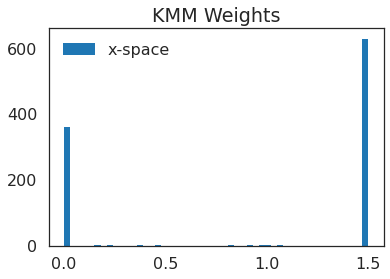

In [51]:
# _ = plt.hist(weights, bins=50, label='x-space')
_ = plt.hist(weights, bins=50, label='x-space')
# plt.yscale('log')

plt.title('KMM Weights')
plt.legend()